In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # mm 
# The initial value for t_0
t0 = 51.74 # ns

# flightPathLength = 243 # 105.35 # mm 
# # The initial value for t_0
# t0 = 33 #68.48 # ns

analysis = False
save = True

In [2]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [3]:
tdc, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [4]:
tdc_model = tdc.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

path_main = os.path.join(p, 'tests//data')
filename_main = path_main + '//' + dataset_name + '.h5'

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/tof_calibratin_and_analysis/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
try:
    dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
except:
    dld_pulseVoltage = data['dld/laser_intensity'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [5]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5261.248047,5261.248047,9299.0,634.893066,5.985306,-22.763265
1,5261.248047,5261.248047,9551.0,467.893908,-3.629388,17.032653
2,5261.248047,5261.248047,10161.0,649.486890,-17.828571,23.973061
3,5261.248047,5261.248047,10358.0,646.016742,19.038367,20.980408
4,5261.248047,5261.248047,10581.0,632.588778,22.476735,-6.176327
...,...,...,...,...,...,...
1822981,5708.472656,5708.472656,26372.0,618.042960,-19.993469,-22.922449
1822982,5708.472656,5708.472656,26455.0,612.954324,13.180408,18.751837
1822983,5708.472656,5708.472656,26564.0,453.642984,-8.309388,20.725714
1822984,5708.472656,5708.472656,26777.0,605.561400,18.274286,11.111020


In [6]:
# t0
dld_t = dld_t - t0

In [7]:
# Remove negative and zero TOF
threshold = 70
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_pulseVoltage = dld_pulseVoltage[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

<IPython.core.display.Javascript object>


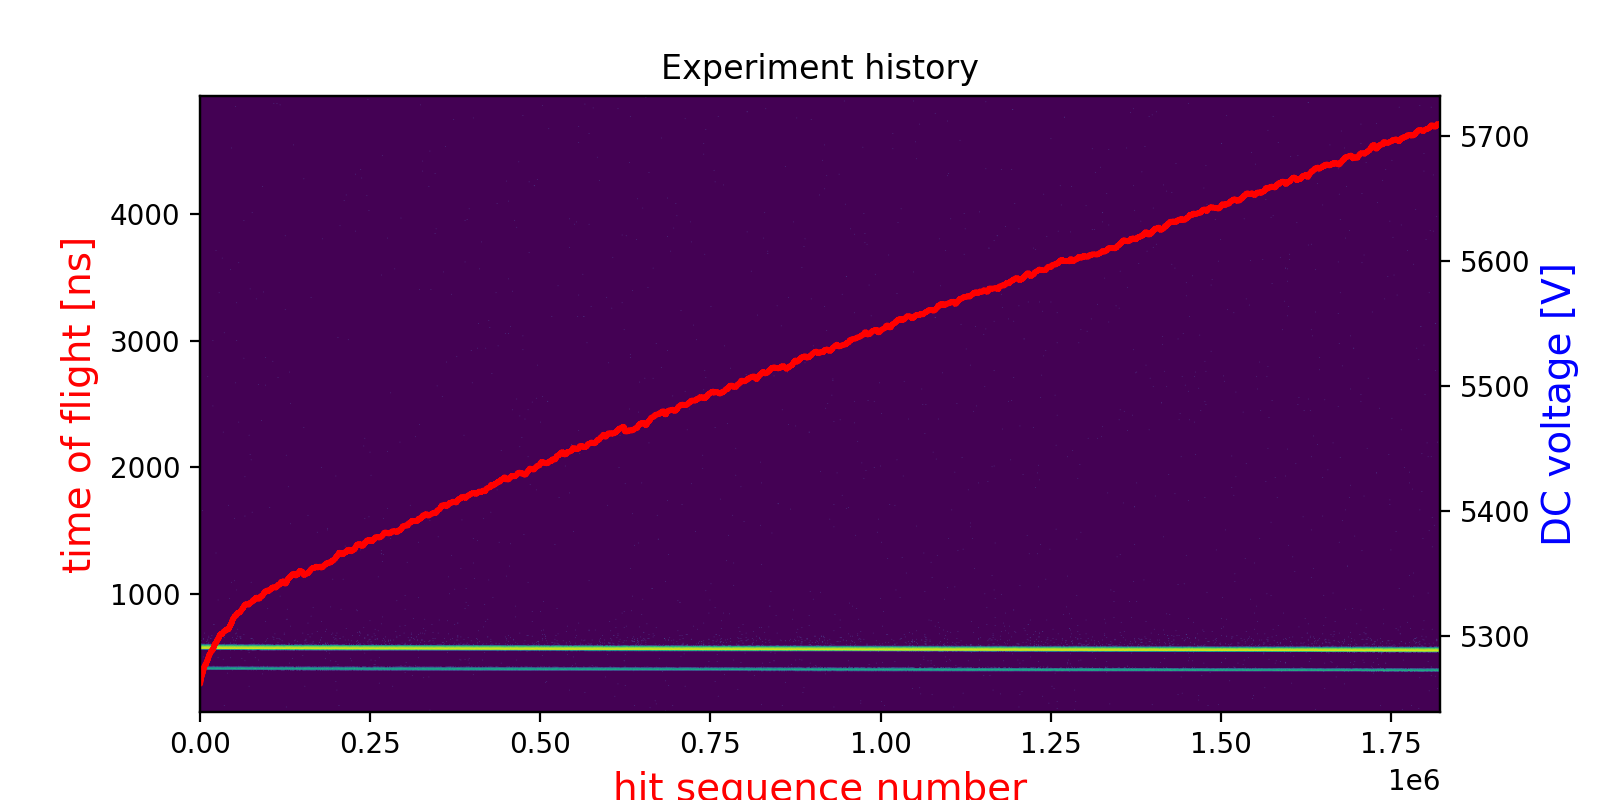

In [8]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

yaxis = dld_t[dld_t < 5000]  # dld_t
# y[y>5000] = 0
xaxis = np.arange(len(yaxis))
heatmap, xedges, yedges = np.histogram2d(xaxis, yaxis, bins=(1200, 800))
heatmap[heatmap == 0] = 1  # to have zero after apply log
heatmap = np.log(heatmap)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# set x-axis label
ax1.set_xlabel("hit sequence number", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("time of flight [ns]", color="red", fontsize=14)
plt.title("Experiment history")
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")

# plot high voltage curve
ax2 = ax1.twinx()

# dldGroupStorage[0] --> dld/high_voltage
high_voltage = dld_highVoltage[dld_t < 5000]
xaxis = np.arange(len(high_voltage))
ax2.plot(xaxis, high_voltage, color='r', linewidth=2)
ax2.set_ylabel("DC voltage [V]", color="blue", fontsize=14)
plt.show()

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

09-12-2022 10:30:56 | INFO | Selected Mode = count
09-12-2022 10:30:56 | INFO | Selected Mode = count
09-12-2022 10:30:56 | INFO | Selected Mode = count
09-12-2022 10:30:56 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


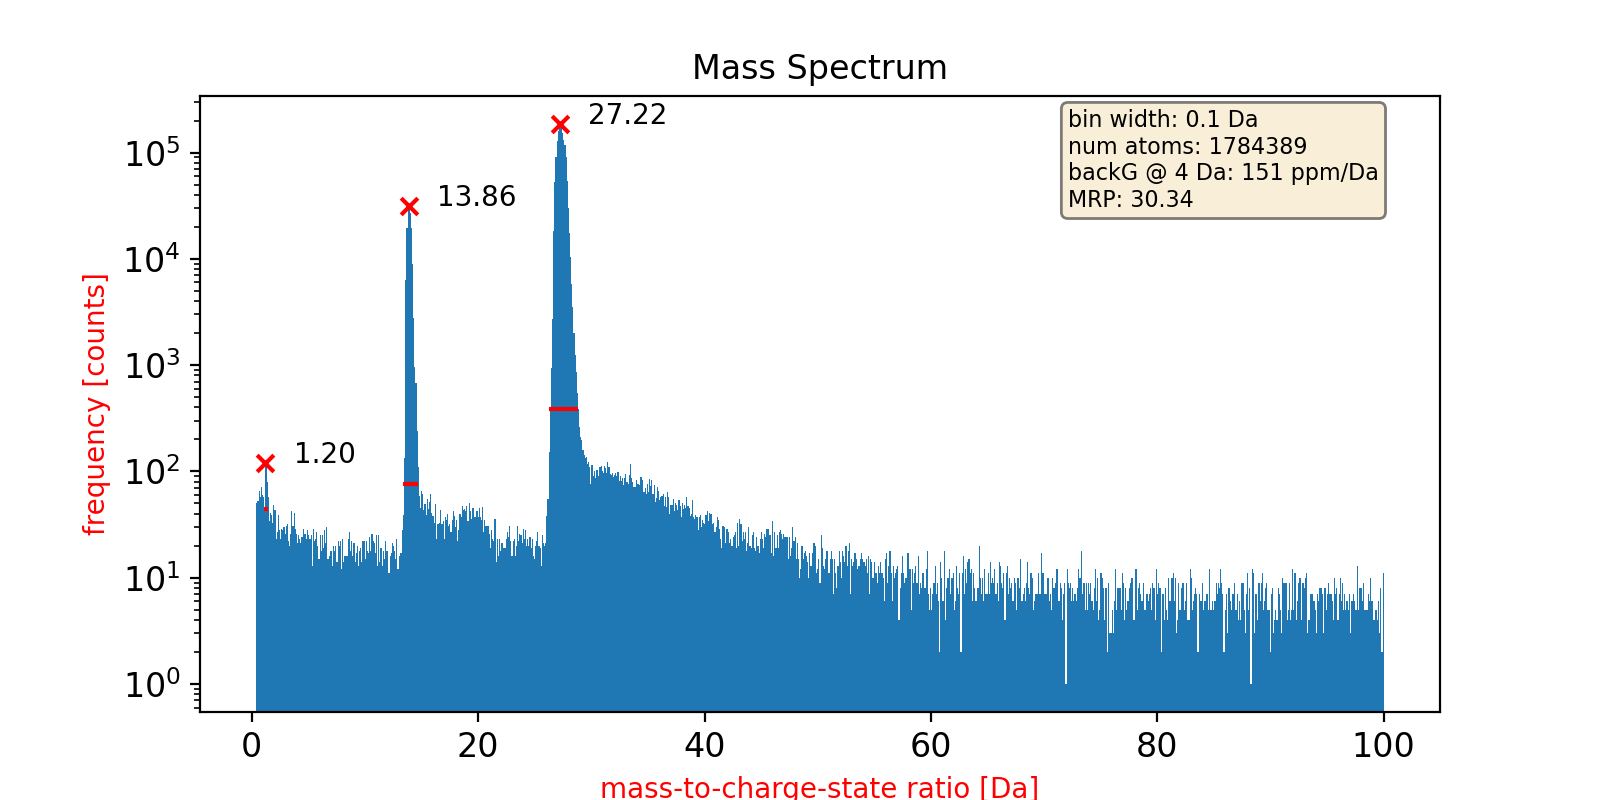

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [30.33924256]
Peaks  0 is: 1.20 peak window sides are: 1.10 - 1.40
Peaks  1 is: 13.86 peak window sides are: 13.56 - 14.16
Peaks  2 is: 27.22 peak window sides are: 26.82 - 27.72


In [9]:
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist_ini, left_right_peaks_ini, peaks_sides_ini, max_paek_edges_ini, index_max_ini = tools.massSpecPlot(mc_seb_ini[mc_seb_ini < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name=figname)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))

In [10]:
print('################ Before starting the calibration ################')
print('Maximum pick value:', max_hist_ini, 'right-left side of the peak:', left_right_peaks_ini)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))
print('#################################################################')

################ Before starting the calibration ################
Maximum pick value: [27.22075432] right-left side of the peak: [26.82199312 27.71920584]
Mass resolving power (MRP --> m/m_2-m_1): [30.33924256]
Peaks  0 is: 1.20 peak window sides are: 1.10 - 1.40
Peaks  1 is: 13.86 peak window sides are: 13.56 - 14.16
Peaks  2 is: 27.22 peak window sides are: 26.82 - 27.72
#################################################################


09-12-2022 10:33:25 | INFO | Selected Mode = count
09-12-2022 10:33:25 | INFO | Selected Mode = count
09-12-2022 10:33:25 | INFO | Selected Mode = count
09-12-2022 10:33:25 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


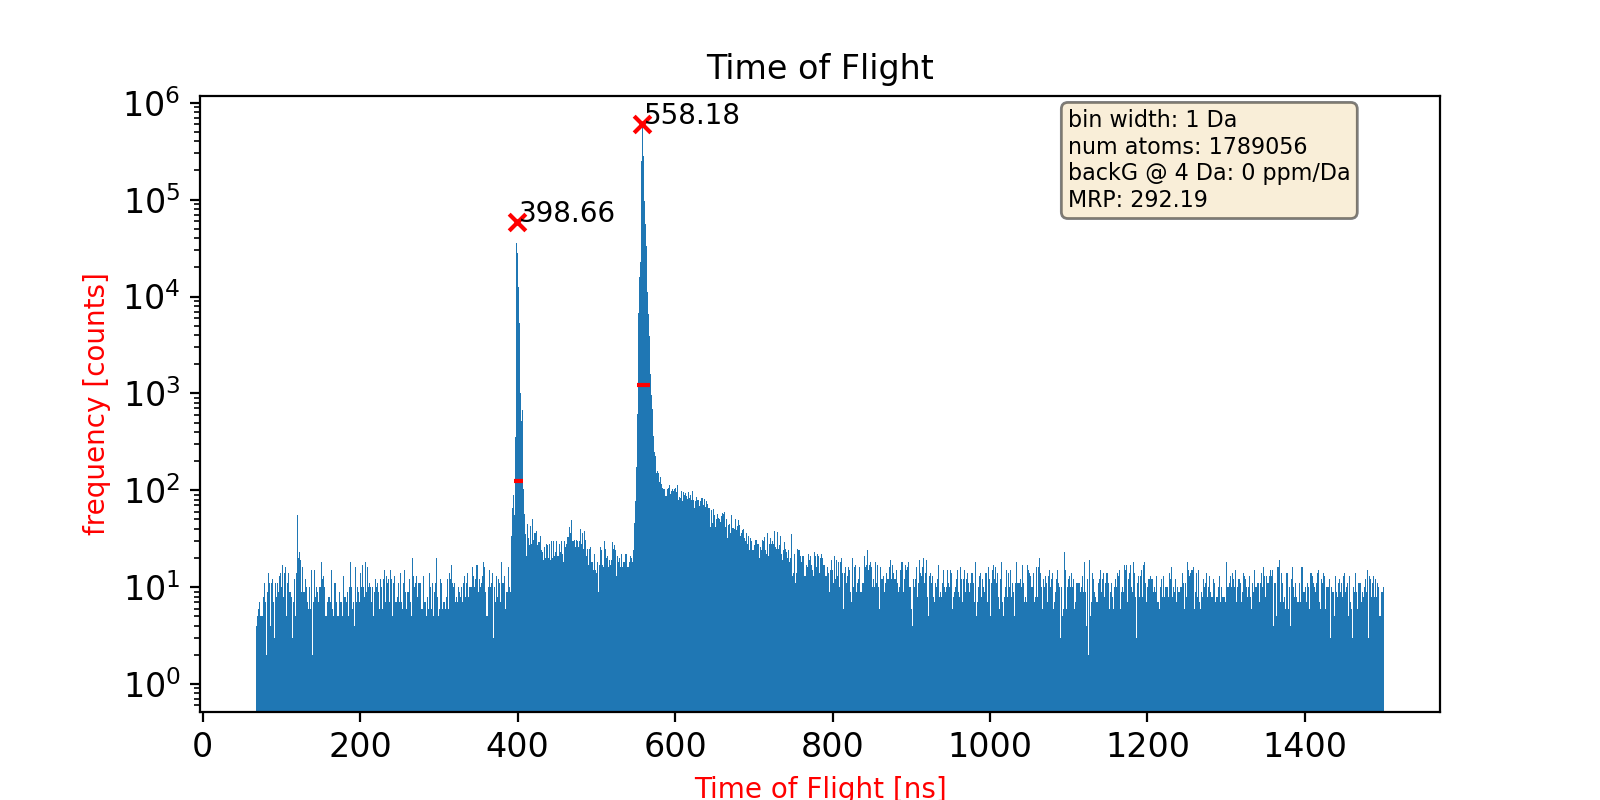

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [292.18543635]
Peaks  0 is: 398.66 peak window sides are: 396.75 - 399.62
Peaks  1 is: 558.18 peak window sides are: 557.22 - 559.13


In [32]:
max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t[dld_t < 1500], 1, distance=100, percent=50, prominence=100, plot=True, label='tof', fig_name=figname)
mrp = (max_hist_tof / (left_right_peaks_tof[1] - left_right_peaks_tof[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_tof)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof[i,2], peaks_sides_tof[i,3]))

In [33]:
if analysis:
    fig1, ax1 = plt.subplots(figsize=(8, 4))

    mask_temporal = np.logical_and((max_paek_edges_tof[0] < dld_t), (dld_t < max_paek_edges_tof[1]))

    v_dc = dld_highVoltage[mask_temporal]
    tt = dld_t[mask_temporal]

    x = plt.scatter(v_dc, tt, color="blue", label='t', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


    flight_distance = np.sqrt(flightPathLength**2 + dld_x[mask_temporal]**2 + dld_y[mask_temporal]**2)

    t_corr = np.sqrt(((flight_distance*1E-3)**2 * np.tile(np.array(26.98), len(dld_highVoltage[mask_temporal]))*1.66E-27)/(2 * 1.6E-19 * dld_highVoltage[mask_temporal]))
    y = plt.scatter(dld_highVoltage[mask_temporal], t_corr*1E9, color="red", label='t_corr', alpha=0.1)


    plt.legend(handles=[x, y], loc='upper right')
    plt.show()

09-12-2022 10:33:36 | INFO | Selected Mode = count
09-12-2022 10:33:36 | INFO | Selected Mode = count
09-12-2022 10:33:36 | INFO | Selected Mode = count
09-12-2022 10:33:36 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


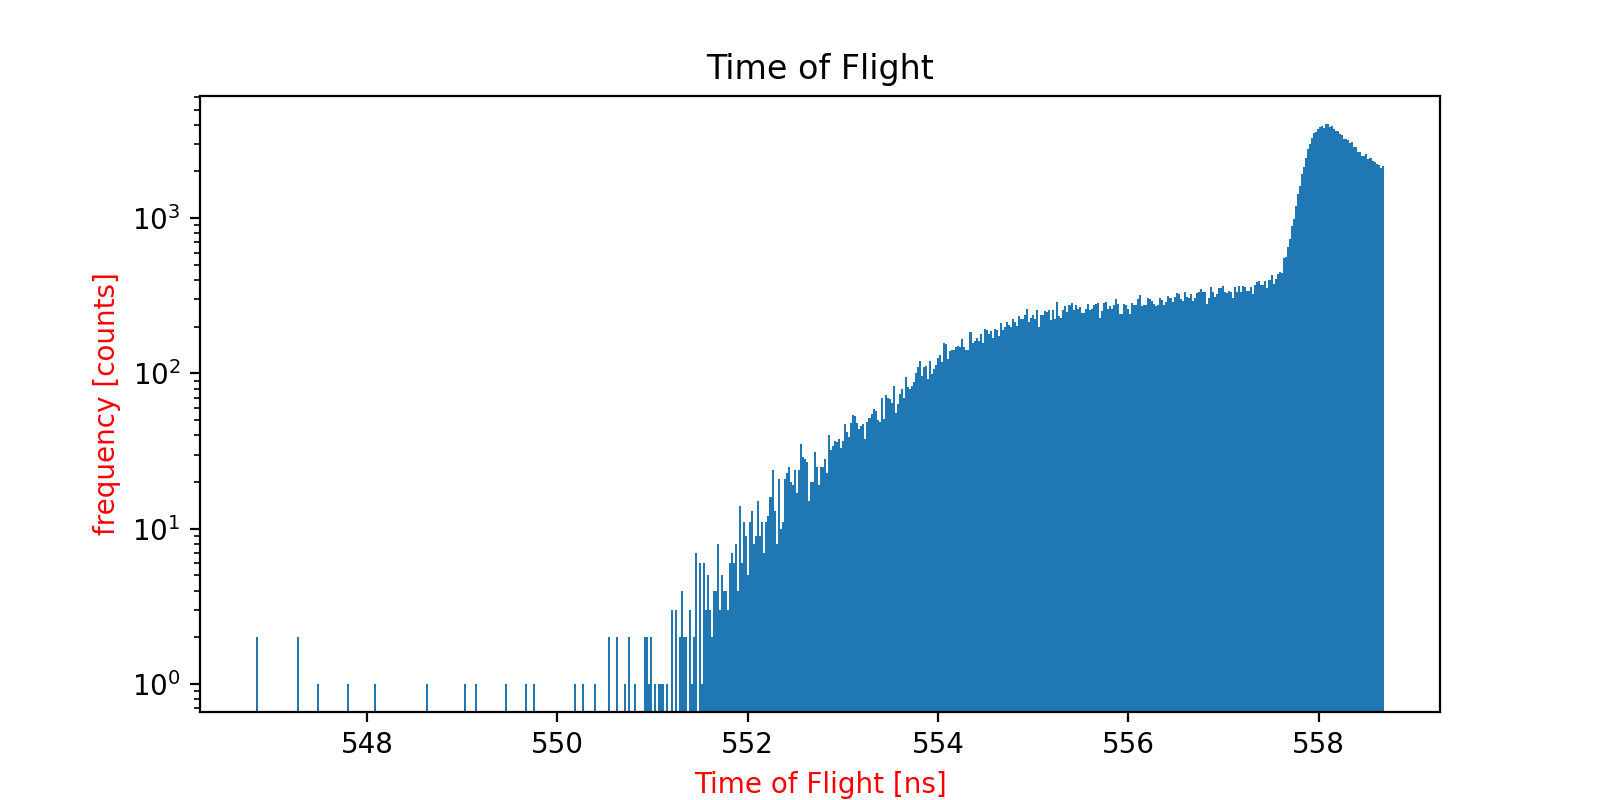

(0, 0, 0, 0, 0)

In [34]:
mask_temporal = np.logical_and((max_paek_edges_tof[0] -5 < dld_t), (dld_t < max_paek_edges_tof[1] - 10))
# mask_temporal = np.logical_and((max_paek_edges_tof[0] < dld_t), (dld_t < max_paek_edges_tof[1]))

dld_t_peak_v = dld_t[mask_temporal]
dld_x_peak_v = dld_x[mask_temporal]
dld_y_peak_v = dld_y[mask_temporal]
dld_highVoltage_peak_v = dld_highVoltage[mask_temporal]
dld_pulseVoltage_peak_v = dld_pulseVoltage[mask_temporal]


# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 2detector_squre mm * 2detector_squre mm
detector_squre = 10

mask_spacial = np.logical_and((np.abs(dld_x_peak_v) < detector_squre), (np.abs(dld_y_peak_v) < detector_squre))

# mask_spacial = np.full(len(dld_t_peak_v), True)

tools.massSpecPlot(dld_t_peak_v[mask_spacial], 1, distance=100, percent=50, prominence=10, peaks_find=False, plot=True, label='tof', text_loc='left', fig_name='peak_'+figname)

In [51]:
if analysis:
    fig1, ax1 = plt.subplots(figsize=(8, 4))


    x = plt.scatter(dld_highVoltage_peak_v[mask_spacial], dld_t_peak_v[mask_spacial], color="blue", label='t', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


    # flight_distance = np.sqrt((flightPathLength*1E-3)**2 + (dld_x_peak_v[mask_spacial]*1E-3)**2 + (dld_y_peak_v[mask_spacial]*1E-3)**2)
    # t_corr = np.sqrt((((flight_distance)**2) * np.tile(max_hist_ini, len(dld_highVoltage_peak_v[mask_spacial]))*1.66E-27)/(2 * 1.6E-19 * dld_highVoltage_peak_v[mask_spacial]))
    t_corr = np.tile(max_hist_tof, len(dld_highVoltage_peak_v[mask_spacial])) * 1E-9

    y = plt.scatter(dld_highVoltage_peak_v[mask_spacial], t_corr*1E9, color="red", label='t_corr', alpha=0.1)


    plt.legend(handles=[x, y], loc='upper right')
    if save==True:
        plt.savefig(variables.result_path + "//peak_tof_corr_%s.svg" % figname, format="svg", dpi=600)
        plt.savefig(variables.result_path + "//peak_tof_corr_%s.png" % figname, format="png", dpi=600)
    plt.show()


In [52]:
def voltage_corr(x, a, b, c, d):
#     return a / np.sqrt((b + (c * x) + (d * (x**2))))
    return (a / (b * (x ** 2) + c * x + d))


def voltage_corection(highVoltage, t):
    fitresult, _ = curve_fit(voltage_corr, highVoltage, t)
    return fitresult

mask = np.random.randint(0, len(dld_highVoltage_peak_v[mask_spacial]), 300)
input_1 = dld_highVoltage_peak_v[mask_spacial]
output_1 =  np.median(dld_t_peak_v[mask_spacial]) / dld_t_peak_v[mask_spacial]

# scaler = MinMaxScaler(feature_range=(0, 1))
# input_1 = scaler.fit_transform(input_1.reshape(-1, 1)).reshape((-1,)) 
# output_1 = scaler.fit_transform(output_1.reshape(-1, 1)).reshape((-1,)) 

fitresult = voltage_corection(input_1[mask], output_1[mask] )


# dld_highVoltage_norm = scaler.fit_transform(dld_highVoltage.reshape(-1, 1)).reshape((-1,)) 
# f_v = voltage_corr(dld_highVoltage_norm, *fitresult)

f_v = voltage_corr(dld_highVoltage, *fitresult)


In [37]:
fitresult

array([ 2.65762287e+04, -1.37906725e-05,  1.07849460e-01,  2.63786059e+04])

<IPython.core.display.Javascript object>


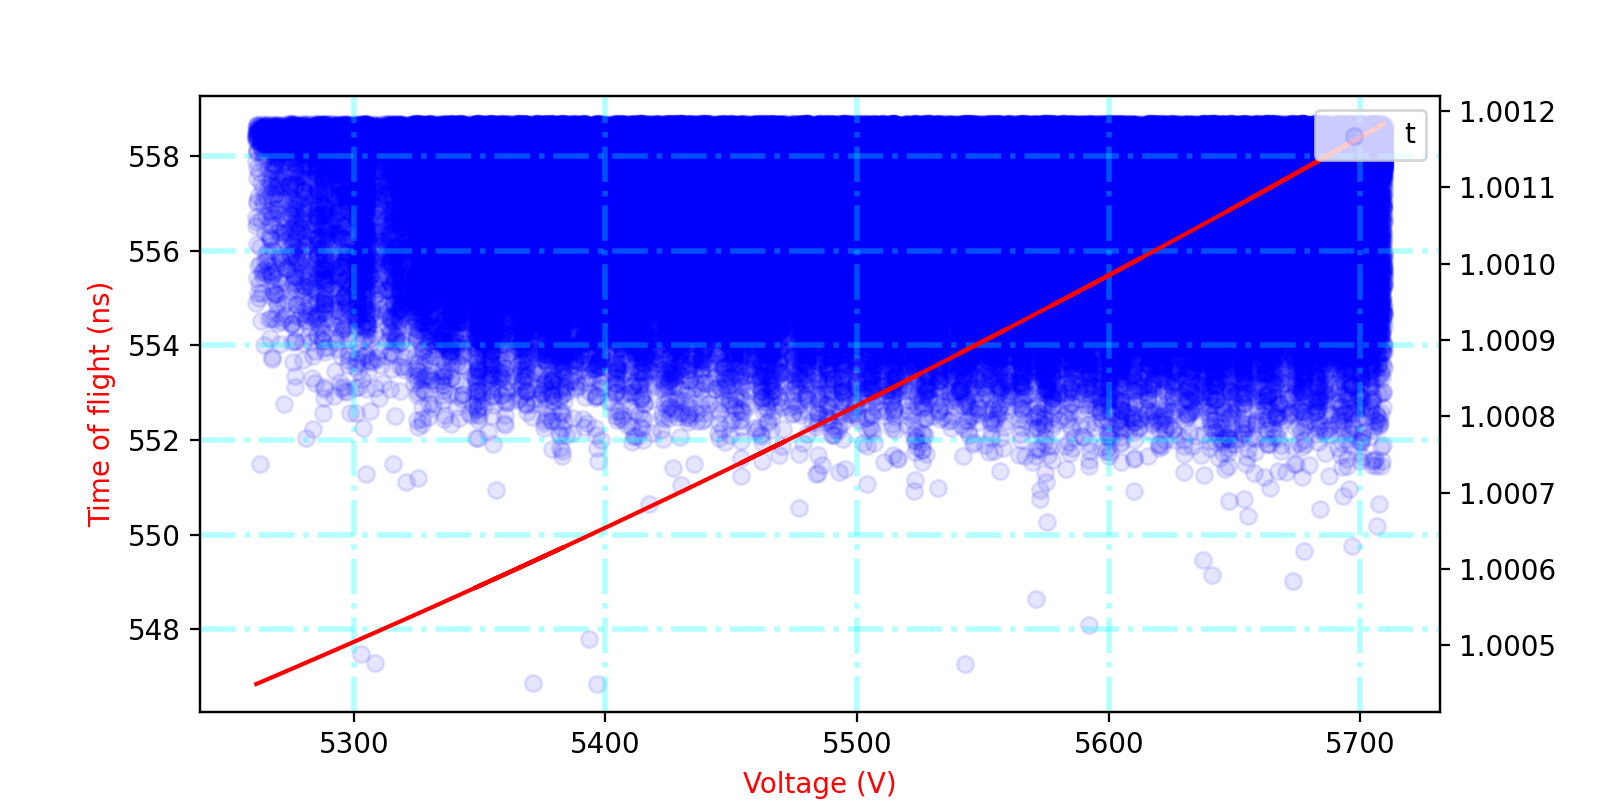

In [38]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

x = plt.scatter(dld_highVoltage_peak_v[mask_spacial], ((dld_t_peak_v[mask_spacial])), color="blue", label='t', alpha=0.1)

ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)

# plot high voltage curve
ax2 = ax1.twinx()
y = ax2.plot(dld_highVoltage_peak_v[mask_spacial], voltage_corr(dld_highVoltage_peak_v[mask_spacial], *fitresult), color='r', label='F_V')

plt.legend(handles=[x], loc='upper right')

if save==True:
    plt.savefig(variables.result_path + "//vol_corr_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//vol_corr_%s.png" % figname, format="png", dpi=600)
    
plt.show()

In [53]:
dld_t_new_v = dld_t * f_v

In [54]:
if analysis==True:
    fig1, ax1 = plt.subplots(figsize=(8, 4))




    x = plt.scatter(dld_highVoltage_peak_v[mask_spacial], dld_t_peak_v[mask_spacial], color="blue", label='t', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


    dld_t_plot = dld_t_new_v[mask_temporal]

    y = plt.scatter(dld_highVoltage_peak_v[mask_spacial], dld_t_plot[mask_spacial], color="red", label='t_corr_v', alpha=0.1)


    plt.legend(handles=[x, y], loc='upper right')
    if save==True:
        plt.savefig(variables.result_path + "//peak_tof_V_corr_%s.svg" % figname, format="svg", dpi=600)
        plt.savefig(variables.result_path + "//peak_tof_V_corr_%s.png" % figname, format="png", dpi=600)
    plt.show()

09-12-2022 10:34:23 | INFO | Selected Mode = count
09-12-2022 10:34:23 | INFO | Selected Mode = count
09-12-2022 10:34:23 | INFO | Selected Mode = count
09-12-2022 10:34:23 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


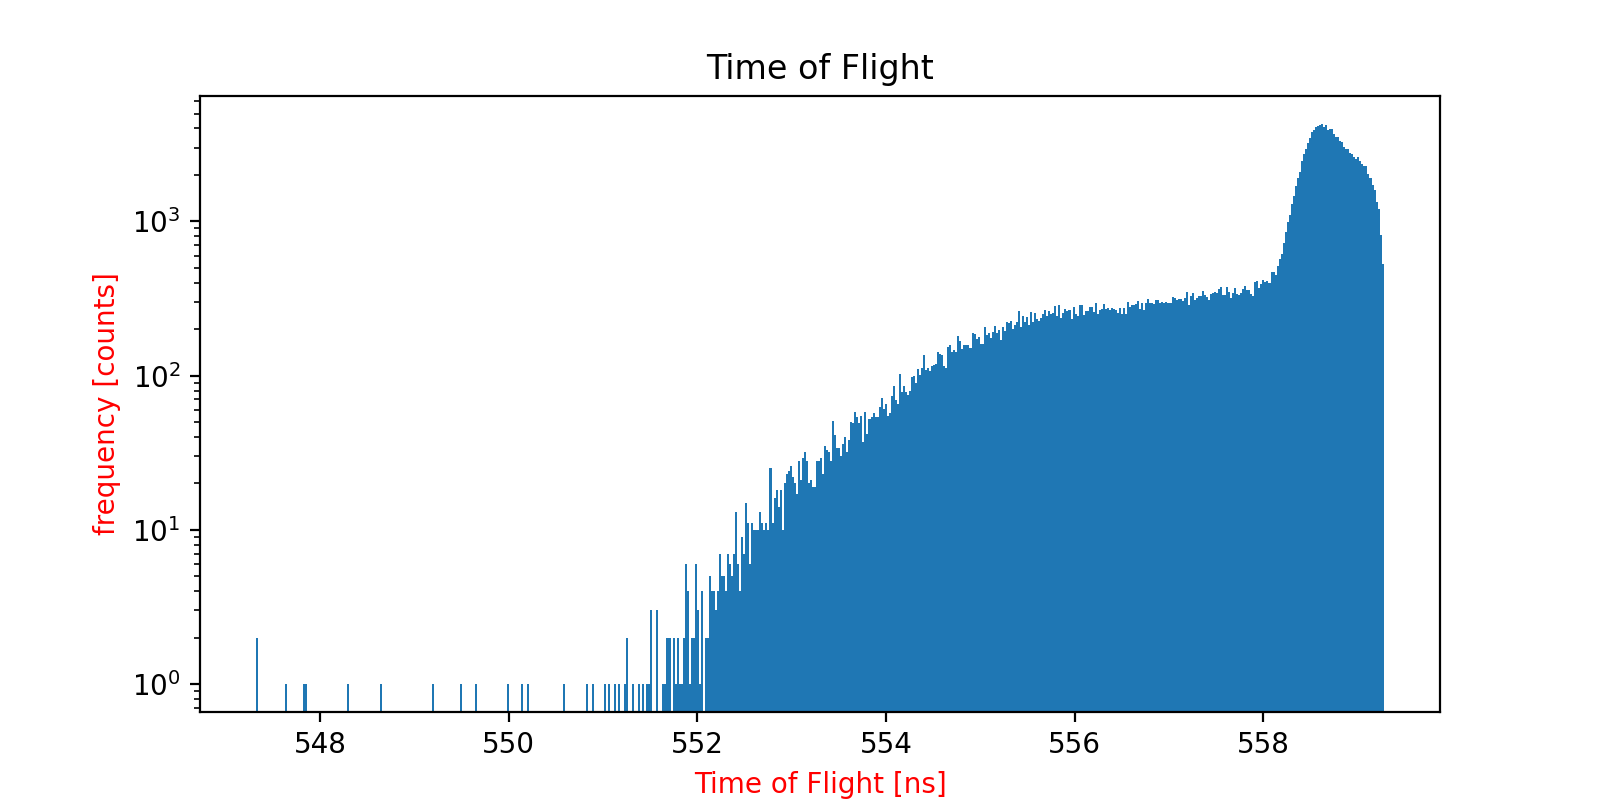

(0, 0, 0, 0, 0)

In [55]:
dld_t_plot = dld_t_new_v[mask_temporal]
tools.massSpecPlot(dld_t_plot[mask_spacial], 1, distance=100, percent=50, prominence=10, plot=True, peaks_find=False, label='tof', text_loc='left', fig_name='peak_'+figname)

09-12-2022 10:34:25 | INFO | Selected Mode = count
09-12-2022 10:34:25 | INFO | Selected Mode = count
09-12-2022 10:34:25 | INFO | Selected Mode = count
09-12-2022 10:34:25 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


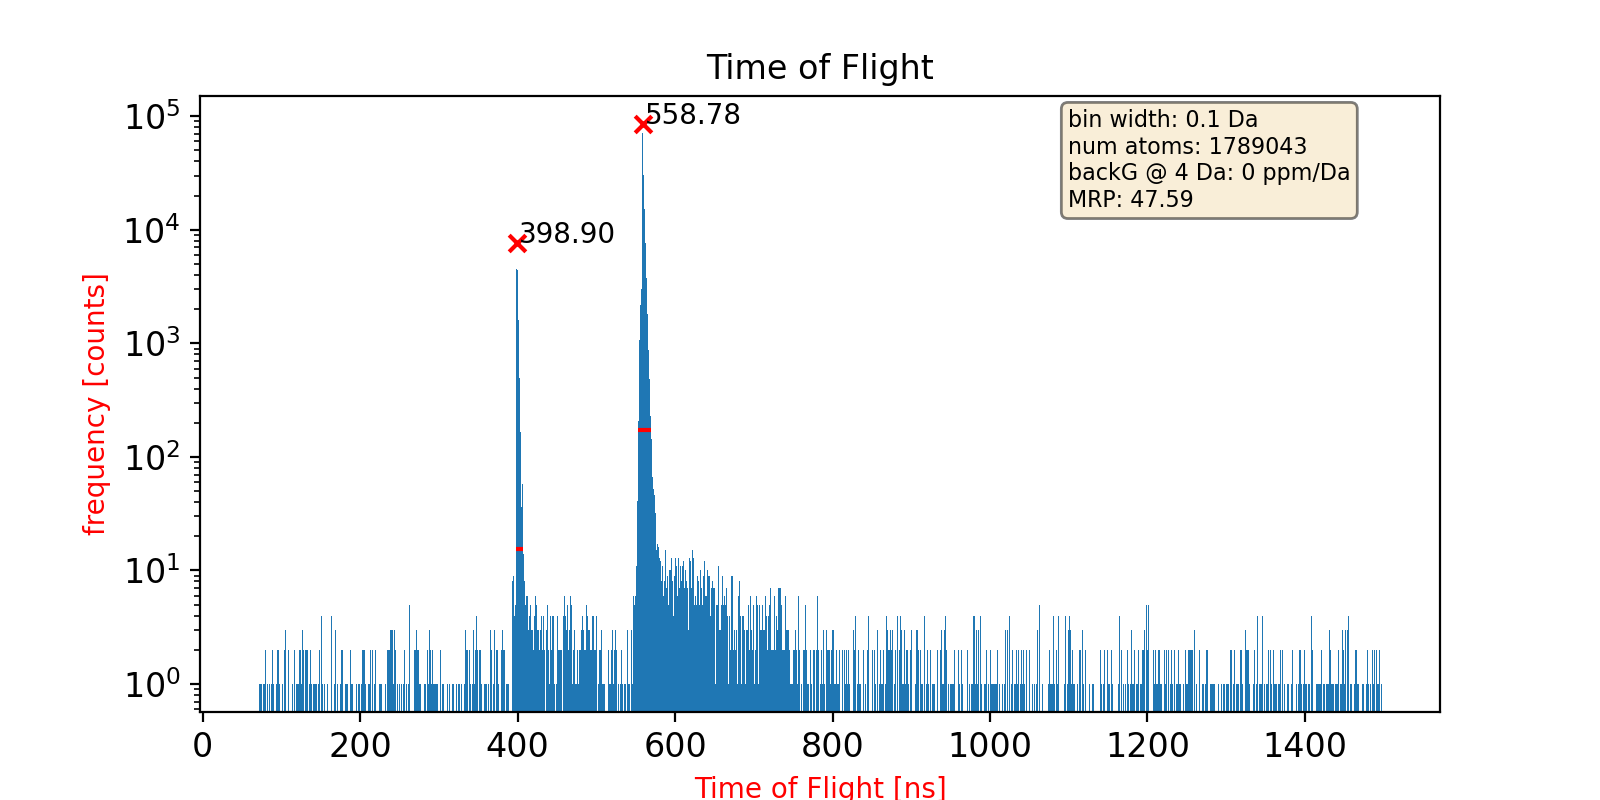

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [47.59252563]
Peaks  0 is: 398.90 peak window sides are: 397.75 - 404.62
Peaks  1 is: 558.78 peak window sides are: 554.58 - 566.32


In [56]:
max_hist_tof_v, left_right_peaks_tof_v, peaks_sides_tof_v, max_paek_edges_tof_v, index_max_tof_v = tools.massSpecPlot(dld_t_new_v[dld_t_new_v < 1500], 0.1, distance=1500, prominence=20, percent=1, plot=True, label='tof', fig_name='V_'+figname)
mrp = (max_hist_tof_v / (left_right_peaks_tof_v[1] - left_right_peaks_tof_v[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_tof_v)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof_v[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof_v[i,2], peaks_sides_tof_v[i,3]))

In [57]:
# max_hist_tof_v, left_right_peaks_tof_v, peaks_sides_tof_v, max_paek_edges_tof_v, index_max_tof_v = tools.massSpecPlot(dld_t[dld_t < 1000], 0.1, distance=1500, prominence=20, percent=1, plot=True, label='tof', fig_name='V_'+figname)
# mrp = (max_hist_tof_v / (left_right_peaks_tof_v[1] - left_right_peaks_tof_v[0]))
# print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
# for i in range(len(peaks_sides_tof_v)):
#     print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof_v[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof_v[i,2], peaks_sides_tof_v[i,3]))

In [58]:
# mask_temporal_bowl = np.logical_and((max_paek_edges_tof_v[0]-5 < dld_t_new_v), (dld_t_new_v < max_hist_tof_v + 30 + (max_hist_tof_v - max_paek_edges_tof_v[0])))
mask_temporal_bowl = np.logical_and((max_paek_edges_tof_v[0] - 10 < dld_t_new_v), (dld_t_new_v < max_paek_edges_tof_v[1] + 40))

dld_t_peak_bowl = dld_t_new_v[mask_temporal_bowl]
dld_x_peak_bowl = dld_x[mask_temporal_bowl]
dld_y_peak_bowl = dld_y[mask_temporal_bowl]
dld_highVoltage_peak_bowl = dld_highVoltage[mask_temporal_bowl]
dld_pulseVoltage_peak_bowl = dld_pulseVoltage[mask_temporal_bowl]

09-12-2022 10:34:41 | INFO | Selected Mode = count
09-12-2022 10:34:41 | INFO | Selected Mode = count
09-12-2022 10:34:41 | INFO | Selected Mode = count
09-12-2022 10:34:41 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


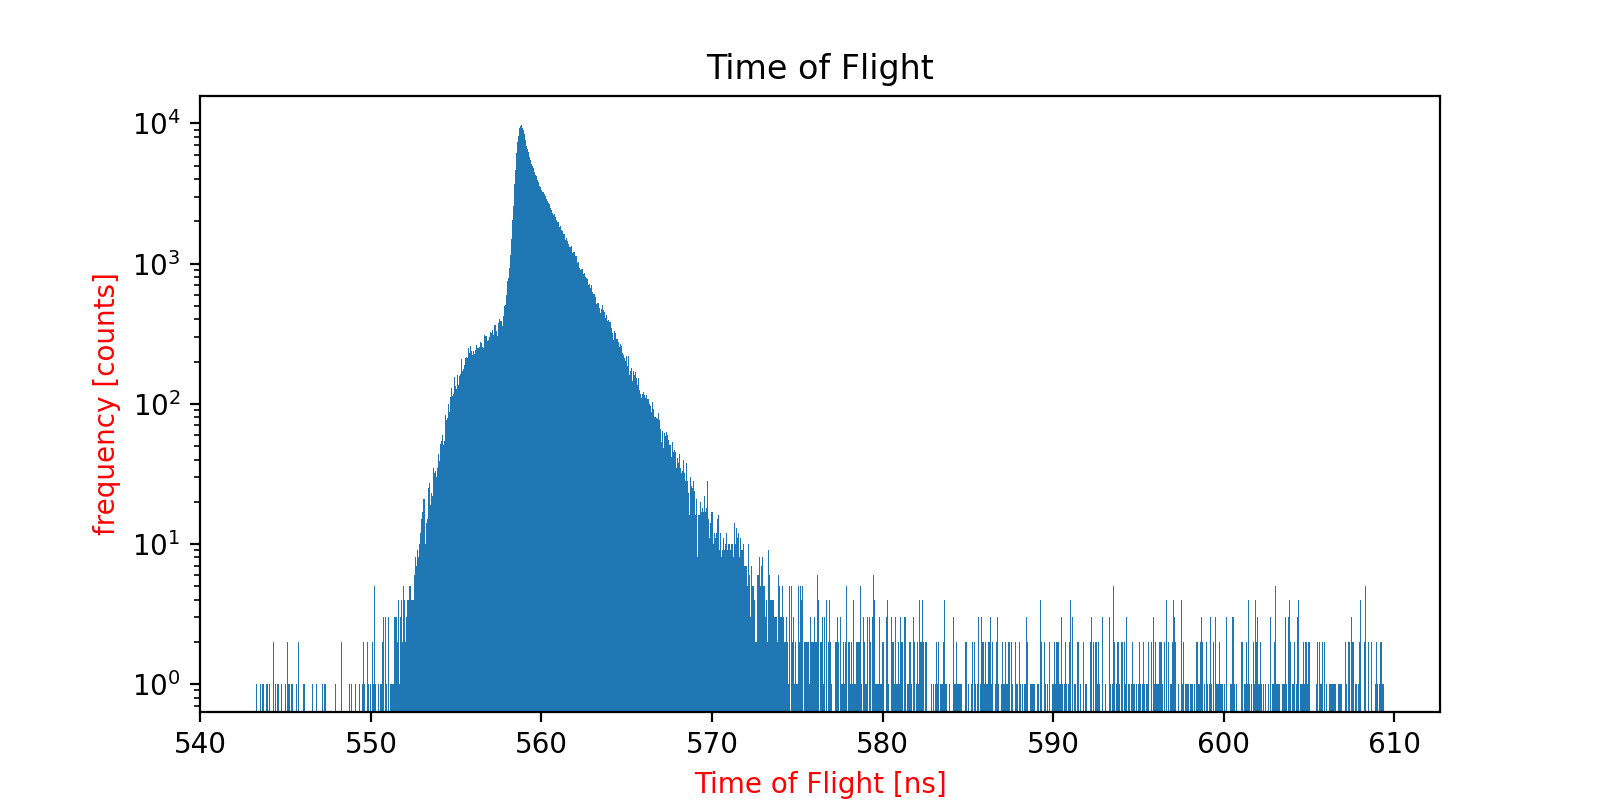

(0, 0, 0, 0, 0)

In [59]:

# vol = 5500
# mask_bowl = np.logical_and((vol - 50 < dld_highVoltage_peak_bowl), (dld_highVoltage_peak_bowl < vol + 50))
mask_bowl = np.full(len(dld_highVoltage_peak_bowl), True)


dld_highVoltage_bowl = dld_highVoltage_peak_bowl[mask_bowl]
dld_pulseVoltage_bowl = dld_pulseVoltage_peak_bowl[mask_bowl]
dld_x_bowl = dld_x_peak_bowl[mask_bowl]
dld_y_bowl = dld_y_peak_bowl[mask_bowl] 
dld_t_bowl = dld_t_peak_bowl[mask_bowl]



tools.massSpecPlot(dld_t_bowl, 0.1, peaks_find=False, distance=1000, percent=50, prominence=100, plot=True, label='tof', fig_name='bowl_pre_corr_'+figname)

In [60]:
def bowl_corr_fit(data_xy, a, b, c, d, e, f):
    x = data_xy[0]
    y = data_xy[1]
#     result = np.sqrt(a + b*x + c*y + d*(x**2) + e*x*y + f*(y**2))
    result = (a + b*x + c*y + d*(x**2) + e*x*y + f*(y**2))
    return result
def bowl_correction(dld_x, dld_y, dld_t):

    parameters, covariance = curve_fit(bowl_corr_fit, [dld_x, dld_y],  dld_t)
    return parameters


scaler2 = MinMaxScaler(feature_range=(-1, 1))
x_bowl = scaler2.fit_transform(dld_x_bowl.reshape(-1, 1)).reshape((-1,)) 
y_bowl = scaler2.fit_transform(dld_y_bowl.reshape(-1, 1)).reshape((-1,)) 
target_bowl = max_hist_tof_v / dld_t_bowl

parameters = bowl_correction(x_bowl, y_bowl, target_bowl)

dld_x_norm = scaler2.fit_transform(dld_x.reshape(-1, 1)).reshape((-1,)) 
dld_y_norm = scaler2.fit_transform(dld_y.reshape(-1, 1)).reshape((-1,)) 
f_bowl = bowl_corr_fit([dld_x_norm,dld_y_norm], *parameters)


In [61]:
parameters

array([ 9.98017995e-01,  1.87033894e-05, -2.92957228e-05, -1.83232225e-04,
       -7.83052541e-07, -1.63747591e-04])

In [62]:
dld_t_new_bowl = dld_t_new_v * f_bowl

<IPython.core.display.Javascript object>


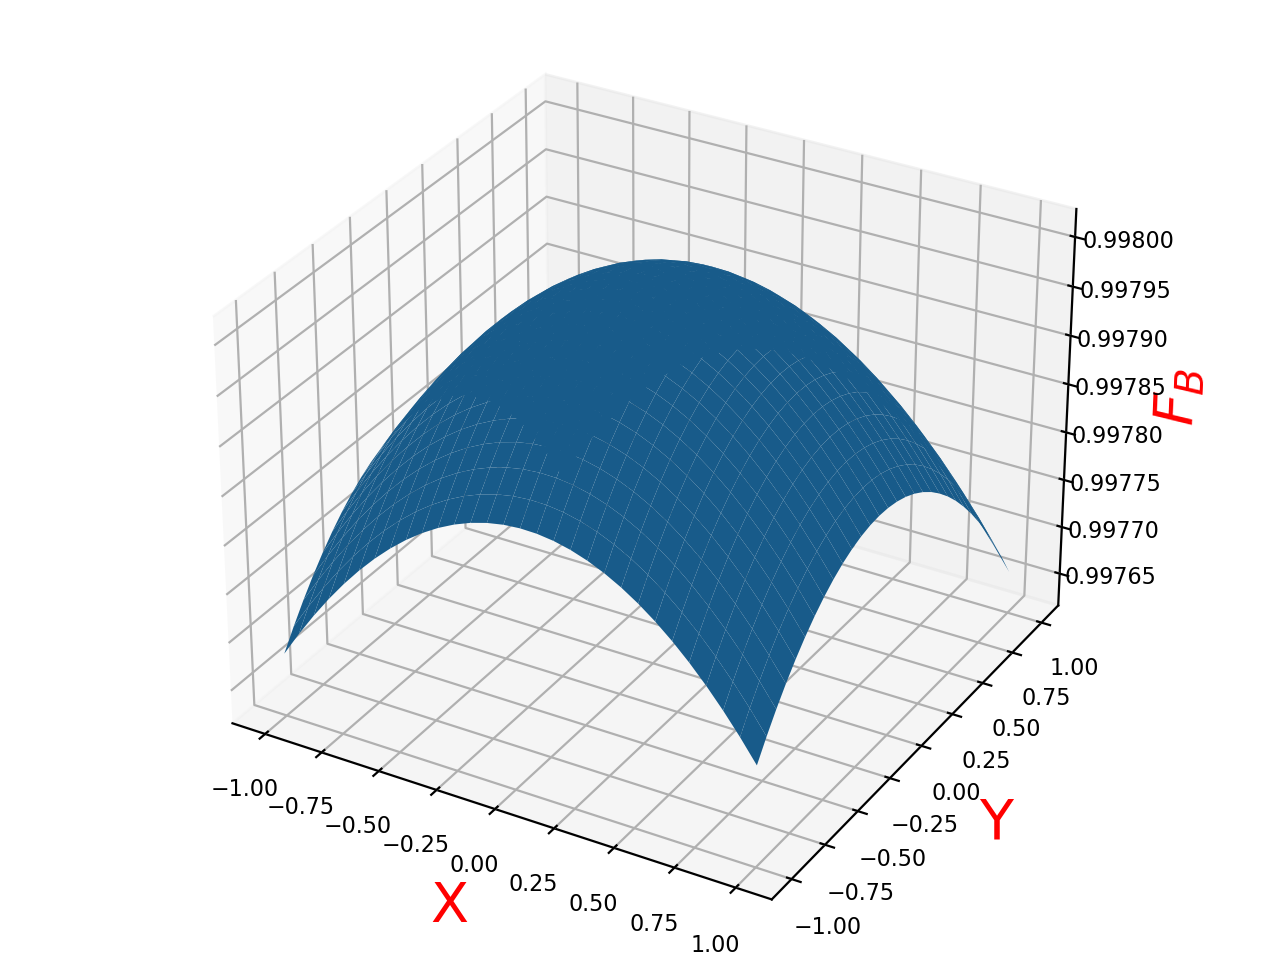

In [63]:
# create surface function model
# setup data points for calculating surface model

model_x_data = np.linspace(-1, 1, 30)
model_y_data = np.linspace(-1, 1, 30)
# create coordinate arrays for vectorized evaluations
X, Y = np.meshgrid(model_x_data, model_y_data)
# calculate Z coordinate array
Z = bowl_corr_fit(np.array([X, Y]), *parameters)

# setup figure object
fig = plt.figure()
# setup 3d object
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# plot surface
ax.plot_surface(X, Y, Z)
# plot input data
# ax.scatter(detxIn, detyIn, mcIn, color='red')
# set plot descriptions
ax.set_xlabel('X', color="red", fontsize=20)
ax.set_ylabel('Y', color="red", fontsize=20)
ax.set_zlabel(r"$F_B$", color="red", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.tick_params(axis='both', which='minor', labelsize=8)

if save==True:
    plt.savefig(variables.result_path + "//bowl_corr_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//bowl_corr_%s.png" % figname, format="png", dpi=600)

plt.show()

In [64]:
if analysis==True:
    fig1, ax1 = plt.subplots(figsize=(8, 4))


    x = plt.scatter(dld_highVoltage_peak_bowl[mask_bowl], dld_t_peak_bowl[mask_bowl], color="blue", label='t', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


    dld_t_plot = dld_t_new_bowl[mask_temporal_bowl]

    y = plt.scatter(dld_highVoltage_peak_bowl[mask_bowl], dld_t_plot[mask_bowl], color="red", label='t_corr_v', alpha=0.1)


    plt.legend(handles=[x, y], loc='upper right')

    if save==True:
        plt.savefig(variables.result_path + "//peak_tof_bowl_corr_%s.svg" % figname, format="svg", dpi=600)
        plt.savefig(variables.result_path + "//peak_tof_bowl_corr_%s.png" % figname, format="png", dpi=600)
    plt.show()


09-12-2022 10:37:38 | INFO | Selected Mode = count
09-12-2022 10:37:38 | INFO | Selected Mode = count
09-12-2022 10:37:38 | INFO | Selected Mode = count
09-12-2022 10:37:38 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


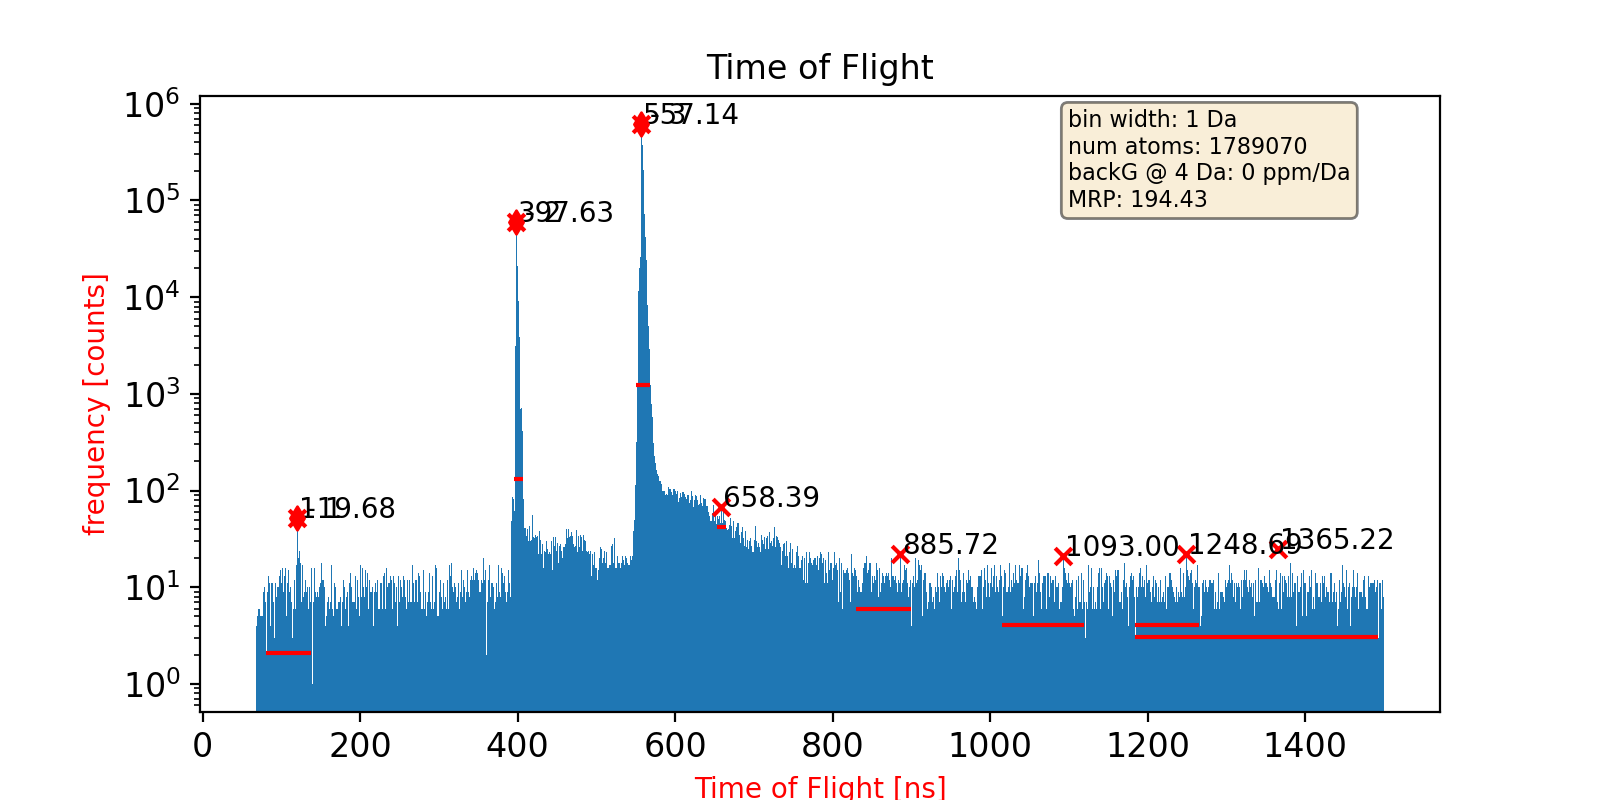

In [71]:
max_hist_tof_bowl, left_right_peaks_tof_bowl, peaks_sides_tof_bowl, max_paek_edges_tof_bowl, index_max_tof_bowl = tools.massSpecPlot(dld_t_new_bowl[dld_t_new_bowl < 1500], 1, distance=100, prominence=15, percent=50, plot=True, label='tof', fig_name='bowl_'+figname)

In [66]:
dld_t = dld_t_new_bowl

In [69]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList,elementIsotopeList,elementMassList,abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0],element[1],element[3]),element[2],)
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown)
display(chargeDropdown)
display(buttonAdd)
display(buttonDelete)
display(buttonReset)
listMaterial = buttonAdd.on_click(wd.onClickAdd)
buttonDelete.on_click(wd.onClickDelete)
buttonReset.on_click(wd.onClickReset)

Dropdown(description='Elements', options=(('H (1) (99.98)', 1.01), ('H (2) (0.01)', 2.01), ('He (3) (0.00)', 3…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

In [72]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(peaks_sides_tof_bowl[variables.peaks_idx[i],0])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(listMaterial)
print('highest peak in the mc histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', variables.listMaterial)

highest peak in the mc histogram: [119.67597885 397.63113525 557.14491916]
highest peak in the ideal mc histogram: [1.01, 13.49, 26.98]


In [73]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal)
    return fitresult

fitresult = parametric_calib(peaks_chos,  variables.listMaterial)


mc_p_1 = parametric(dld_t, *fitresult)

C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


09-12-2022 10:38:17 | INFO | Selected Mode = count
09-12-2022 10:38:17 | INFO | Selected Mode = count
09-12-2022 10:38:17 | INFO | Selected Mode = count
09-12-2022 10:38:17 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


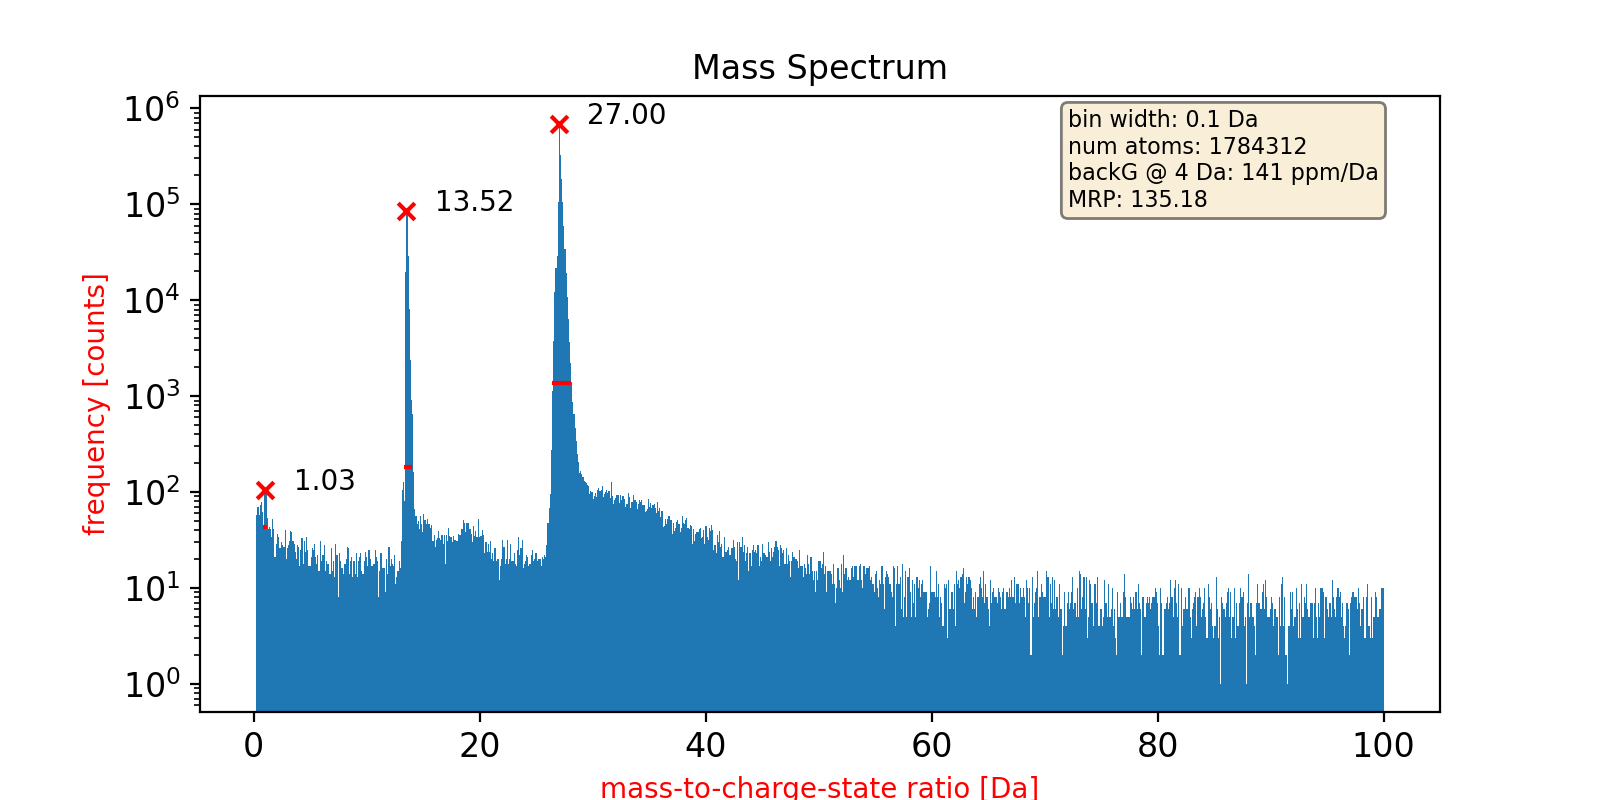

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [135.17883945]
Peaks  0 is: 1.03 peak window sides are: 0.83 - 1.23
Peaks  1 is: 13.52 peak window sides are: 13.42 - 13.62
Peaks  2 is: 27.00 peak window sides are: 26.90 - 27.10


In [74]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_1[mc_p_1 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc2_p_1'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [75]:
delta_t = interpolate.interp1d(peaks_chos, variables.listMaterial, kind='linear', fill_value="extrapolate")
mc_p_2 = delta_t(dld_t)  


09-12-2022 10:43:17 | INFO | Selected Mode = count
09-12-2022 10:43:17 | INFO | Selected Mode = count
09-12-2022 10:43:17 | INFO | Selected Mode = count
09-12-2022 10:43:17 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


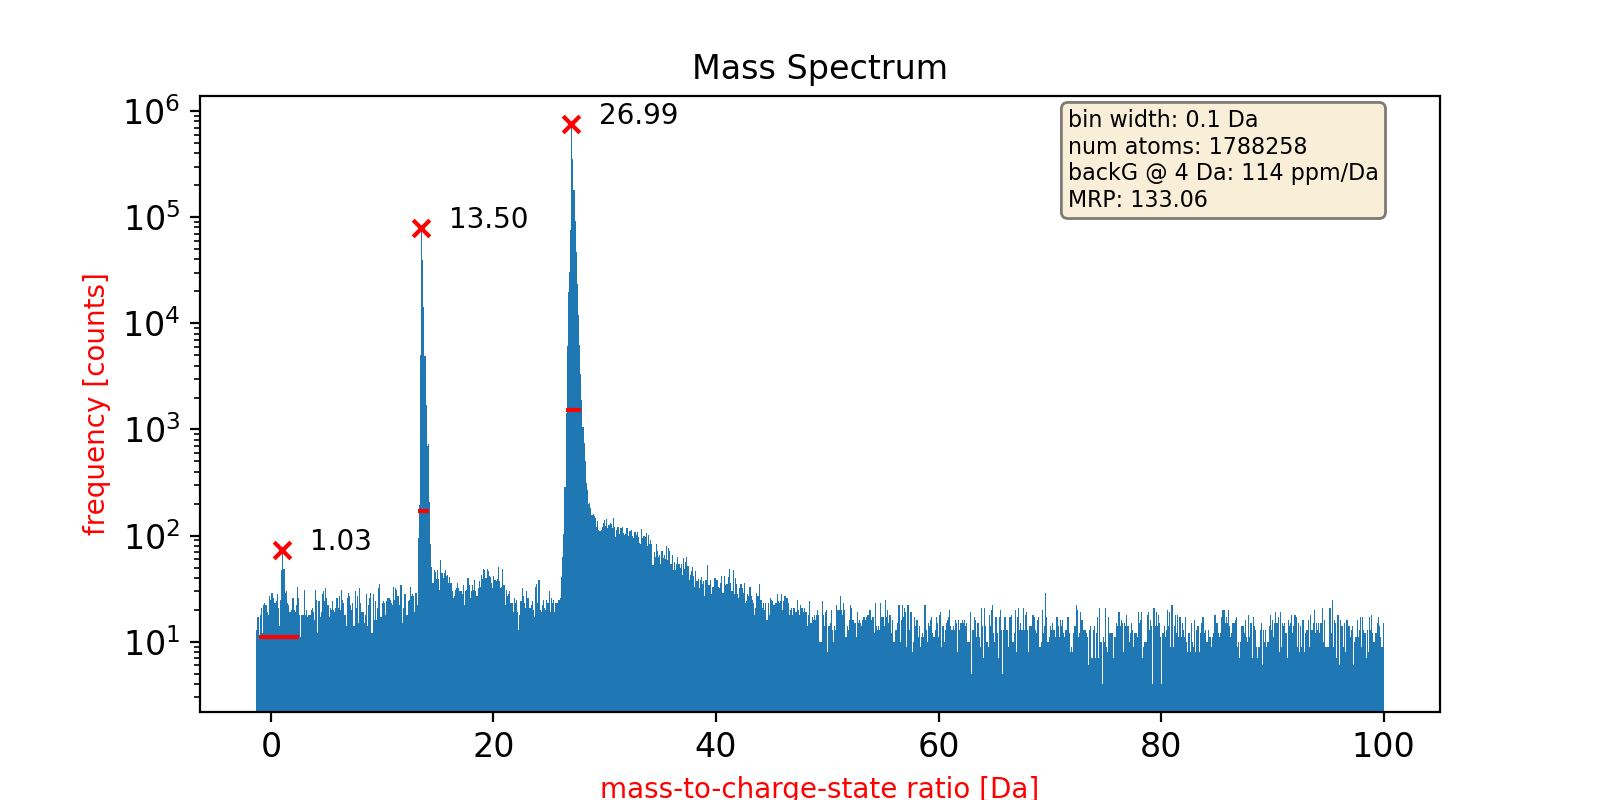

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [133.06092767]
Peaks  0 is: 1.03 peak window sides are: 0.82 - 1.23
Peaks  1 is: 13.50 peak window sides are: 13.40 - 13.70
Peaks  2 is: 26.99 peak window sides are: 26.88 - 27.09


In [76]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_2[mc_p_2 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc2_p_2'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [77]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal)
    return fitresult

fitresult = parametric_calib(peaks_chos,  variables.listMaterial)


parametric_peak = parametric(peaks_chos, *fitresult)

delta_peak = variables.listMaterial - parametric_peak

delta_t = interpolate.interp1d(parametric_peak, delta_peak, kind='linear', fill_value="extrapolate")

 
mc_p_3 = parametric(dld_t, *fitresult) + delta_t(dld_t)


09-12-2022 10:43:28 | INFO | Selected Mode = count
09-12-2022 10:43:28 | INFO | Selected Mode = count
09-12-2022 10:43:28 | INFO | Selected Mode = count
09-12-2022 10:43:28 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


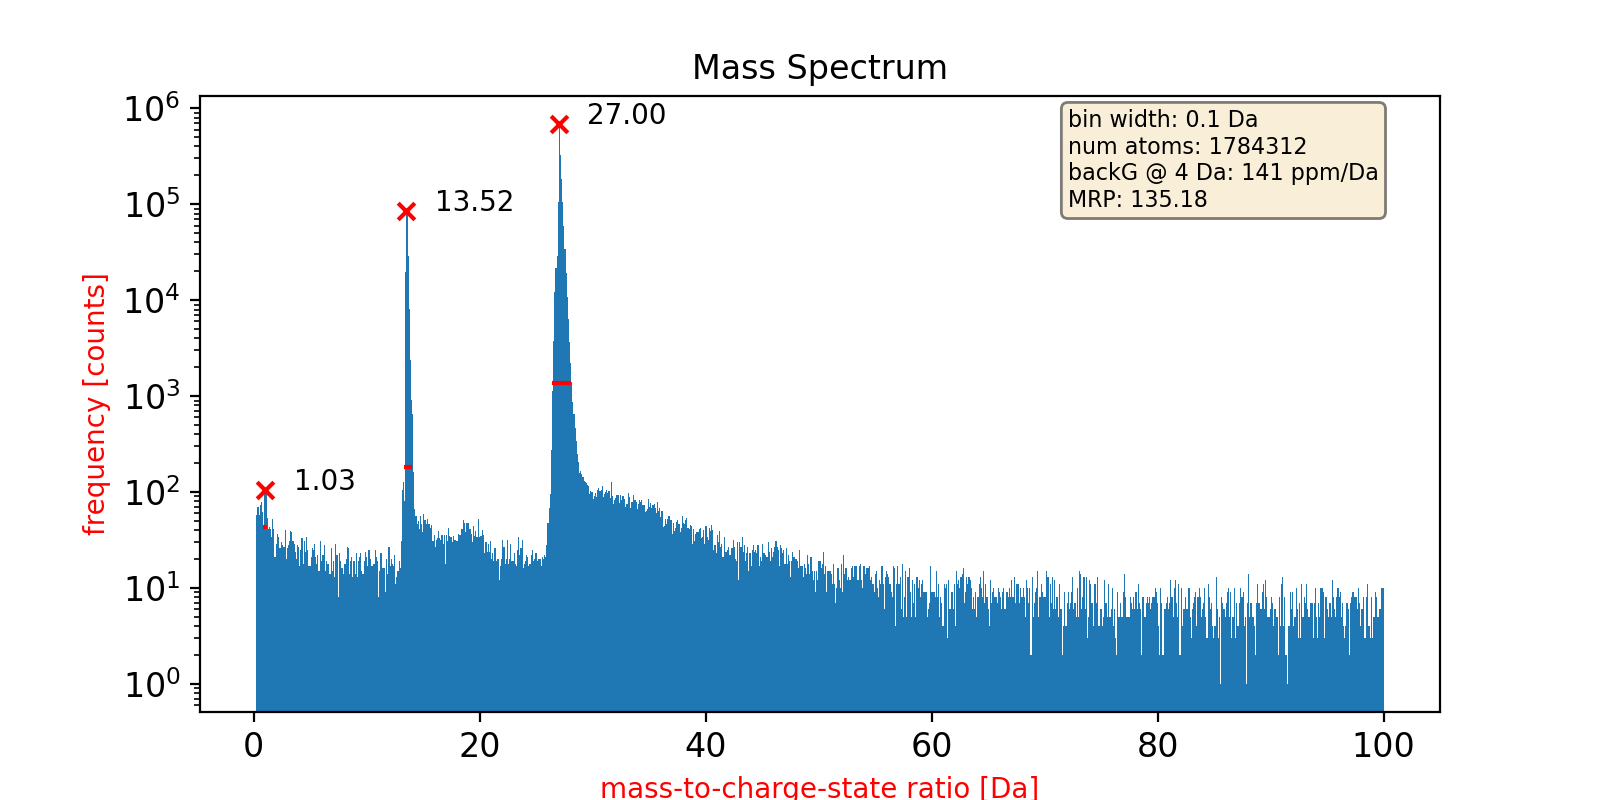

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [135.17883945]
Peaks  0 is: 1.03 peak window sides are: 0.83 - 1.23
Peaks  1 is: 13.52 peak window sides are: 13.42 - 13.62
Peaks  2 is: 27.00 peak window sides are: 26.90 - 27.10


In [78]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_3[mc_p_3 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc_p_3'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [79]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal)
    return fitresult



delta_t = interpolate.interp1d(peaks_chos, variables.listMaterial, kind='linear', fill_value="extrapolate")

linear_peak = delta_t(peaks_chos)

delta_peak = variables.listMaterial - linear_peak

fitresult = parametric_calib(peaks_chos,  delta_peak)



 
mc_p_4 = parametric(dld_t, *fitresult) + delta_t(dld_t)

09-12-2022 10:43:30 | INFO | Selected Mode = count
09-12-2022 10:43:30 | INFO | Selected Mode = count
09-12-2022 10:43:30 | INFO | Selected Mode = count
09-12-2022 10:43:30 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


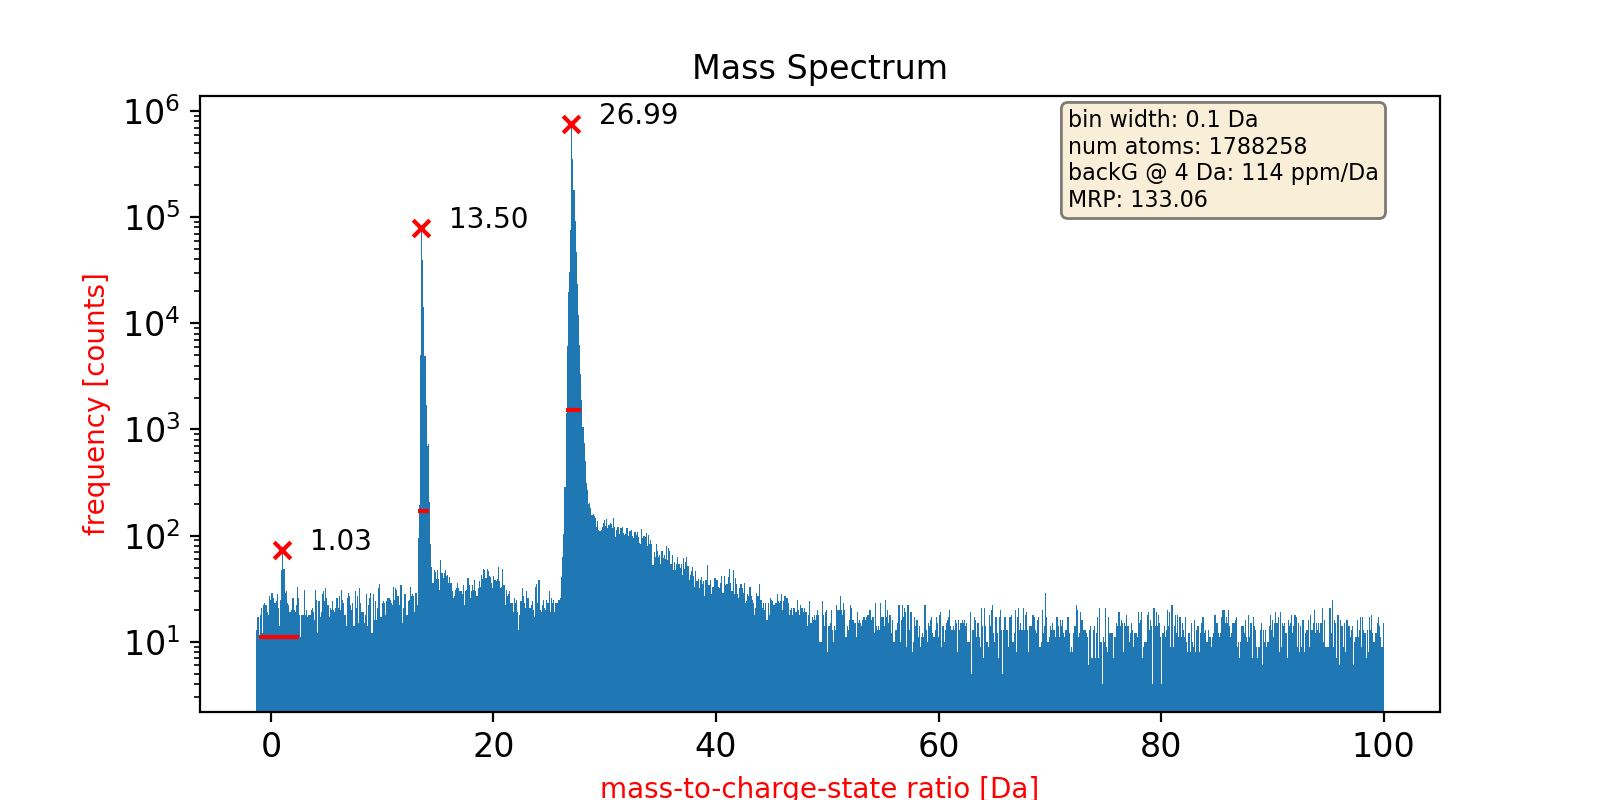

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [133.06092767]
Peaks  0 is: 1.03 peak window sides are: 0.82 - 1.23
Peaks  1 is: 13.50 peak window sides are: 13.40 - 13.70
Peaks  2 is: 26.99 peak window sides are: 26.88 - 27.09


In [80]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_4[mc_p_4 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc_p_4'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [81]:
# add calibrated tof and mc to hdf file
data_loadcrop.add_tof_mc_data_to_hdf5(filename_main, dld_t, mc_p_1)
data_loadcrop.add_tof_mc_data_to_hdf5(filename, dld_t, mc_p_1)
